In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import *
from sklearn.linear_model import *
from math import *
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str('photos/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str('photos/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [5]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [6]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [7]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

In [8]:
example_monet

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[-0.69411767, -0.5529412 , -1.        ],
         [-0.5058824 , -0.372549  , -0.8039216 ],
         [-0.1372549 , -0.00392157, -0.35686272],
         ...,
         [-0.05882353,  0.09019613, -0.06666666],
         [-0.14509803,  0.0196079 , -0.12941176],
         [-0.08235294,  0.09803927, -0.05882353]],

        [[-0.27843136, -0.3960784 , -0.85882354],
         [-0.17647058, -0.24705881, -0.6784314 ],
         [ 0.03529418,  0.00392163, -0.36470586],
         ...,
         [-0.01176471,  0.13725495,  0.09019613],
         [-0.08235294,  0.082353  ,  0.02745104],
         [-0.02745098,  0.15294123,  0.09019613]],

        [[-0.11372548, -0.23137254, -0.7411765 ],
         [-0.00392157, -0.09803921, -0.5686275 ],
         [ 0.11372554,  0.05882359, -0.36470586],
         ...,
         [ 0.00392163,  0.18431377,  0.2313726 ],
         [-0.05882353,  0.12941182,  0.16078436],
         [-0.01960784,  0.1686275 ,  0.2000000

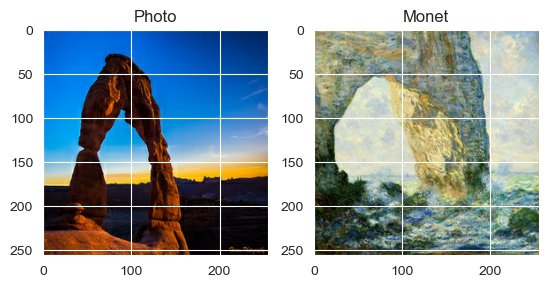

In [9]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [17]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [18]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result